In [37]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector

In [29]:
# CUSUM Tuning
cusum_thresholds = np.arange(2, 20, 0.5)
cusum_bs = np.arange(1, 13, 0.5)
best_f1 = float("-inf")
best_thres = 0
best_b = 0
for thres in cusum_thresholds:
    for cusum_b in cusum_bs:
        env = HillClimbingCar()

        run_tracker = env.run_control_system(   
                config={
                        "params": {
                            "m": 1200,       # Mass (kg)
                            "g": 9.81,       # Gravity (m/s^2)
                            "Cr": 0.01,      # Rolling resistance coefficient
                            "Cd": 0.3,       # Aerodynamic drag coefficient
                            "A": 2.2,        # Frontal area (m^2)
                            "rho": 1.225,    # Air density (kg/m^3)
                            "Fmax": 40000,    # Maximum engine force (N)
                        },
                        "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                        "dt": 0.1,
                        "time": 500,
                        "attack-start": 10,
                        "attack-end": 20,
                        "v-controller": PIDController(0.5, 0.5, 0.01),
                        "target-velocity": 20,
                        "process-noise-cov": np.diag([0.01, 0.1]),
                        "measurement-noise-cov": 0.2,
                        "anomaly-detector": CUSUMDetector(
                            thresholds=thres*np.array([0.16000361755278]),
                            b=np.array([0.18543593999687008]) + cusum_b*np.array([0.16000361755278])),
                    },
                show_plots=False
            )

        time = np.arange(0, 500, 0.1)
        attack_labels = [(x >= 10 and x <= 20) for x in time]
        attack_predictions = run_tracker.get_metrics(metric="attack_predictions")
        cm = confusion_matrix(attack_predictions, attack_predictions)
        prec = precision_score(attack_labels, attack_predictions)
        rec = recall_score(attack_labels, attack_predictions)
        acc = accuracy_score(attack_labels, attack_predictions)
        f1 = f1_score(attack_labels, attack_predictions)
        if f1 > best_f1:
            best_thres = thres
            best_b = cusum_b
            best_f1 = f1
            best_acc = acc
            best_rec = rec
            best_prec = prec
    print(f"-----------------\nParams: {best_thres, best_b}\nAccuracy: {best_acc}\nPrecision: {best_prec}\nRecall: {best_rec}")





/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:

-----------------
Params: (10.5, 7.5)
Accuracy: 0.999
Precision: 0.9897959183673469
Recall: 0.9603960396039604


In [59]:
# MSE
mmsce2 = []
for mag in range(1, 10):
    msce = []
    for _ in range(100):
        env = HillClimbingCar()
        run_tracker = env.run_control_system(   
            config={
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.1,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": mag,
                    "v-controller": PIDController(0.5, 0.5, 0.01),
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.01, 0.1]),
                    "measurement-noise-cov": 0.2,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=10.5*np.array([0.16000361755278]),
                        b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
                },
            show_plots=False
        )
        msce.append(np.mean(run_tracker.ms_control_error()))
    mmsce2.append(msce)


In [55]:
np.mean(msce), np.std(msce)

(6.945416828981613, 1.5582852595428953)

In [60]:
mmsce

[[1.2394993530961018,
  0.716866138378243,
  1.1581001396330879,
  1.1389033716844101,
  1.0945523267092965,
  1.7091209689987186,
  0.706034109934616,
  3.4828932197553297,
  0.7344541354703757,
  6.311446339175192,
  2.54567317878616,
  1.0535296626612074,
  1.8066019725535976,
  1.3755983297873395,
  1.1057262937590928,
  2.881783302155693,
  1.4976330250388534,
  0.7558491138881993,
  6.060332259576027,
  3.997509315922697,
  5.962353706069826,
  0.7004465416496831,
  0.8282993775018788,
  0.9483777670833048,
  1.1497341932706537,
  6.541297413143342,
  1.6139683762919166,
  5.137223028486922,
  2.218280187335575,
  2.409805344608582,
  3.938866757738063,
  6.369770293690431,
  1.1764569069653537,
  1.5695516908387863,
  1.438501917056007,
  7.624018800746597,
  14.960414406451992,
  1.8759742672216437,
  1.0286292609757757,
  2.4498358705841037,
  1.6742153115835692,
  3.2977135958103525,
  0.7715838604345964,
  1.590671280377795,
  3.4219876318813736,
  2.130609104344831,
  2.475

In [61]:
mmsce2

[[1.5251730983538587,
  2.1582316307355347,
  5.007142021239392,
  3.6561127155290154,
  2.9172005080130834,
  0.8416749831022722,
  1.9383284038341022,
  6.42452664311261,
  1.223095026554377,
  3.1573774291053285,
  2.341583516456729,
  1.657607064800578,
  2.1488891994528045,
  7.218700789020254,
  0.8782201954205016,
  1.3205303742761794,
  0.6992833752095161,
  1.9745663972816805,
  1.4835476709766857,
  0.9132654789292409,
  2.618703745312464,
  10.894040518286682,
  0.5299272252342319,
  1.6613053160726925,
  6.760011163264392,
  2.4490572980596834,
  0.6675312552638144,
  6.3960449922808005,
  0.9079793649425546,
  1.0675875281791793,
  1.4202443638319577,
  5.54011070800346,
  1.2827251306533975,
  4.480590951983375,
  17.269447112547283,
  11.235723799333984,
  1.8590750002474126,
  17.17600049209218,
  1.09416955712739,
  29.744775263561344,
  1.2016916867263923,
  8.015605455655335,
  4.235536469712787,
  0.8669386727329991,
  3.254980349305943,
  2.908568947025157,
  7.768

In [62]:
stats_base = [(np.mean(x), np.std(x)) for x in mmsce]
stats_ekf = [(np.mean(x), np.std(x)) for x in mmsce2]

In [63]:
stats_base

[(2.832507781423014, 2.731966852696139),
 (2.906980539729489, 2.3189911477739122),
 (3.974419222679005, 2.8821740646782383),
 (5.537558540264455, 2.6694691515266897),
 (6.988408049771854, 2.927412225644281),
 (9.073915296944083, 1.6407056926518482),
 (12.315243616441679, 2.469814534505944),
 (15.5058404754815, 2.0476267257742724),
 (20.36054567598587, 2.653298301283018)]

In [64]:
stats_ekf

[(4.291068675995974, 4.583600381541723),
 (5.493661806515961, 7.155542485222117),
 (4.293363980709232, 5.160414171290278),
 (4.44336095821563, 4.470654243522835),
 (5.201131238377831, 5.4657732726985655),
 (5.792390113324972, 7.833562170562348),
 (5.529581769538132, 3.9235456914677393),
 (6.270337314794597, 3.901243670583415),
 (7.22152837068931, 4.075659918571724)]

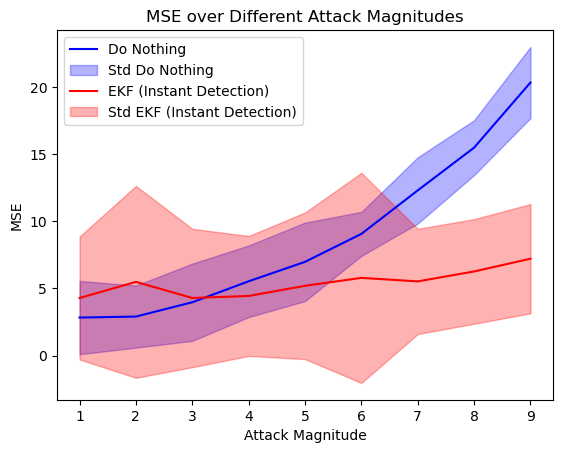

In [68]:
plt.plot(range(1, 10), [x[0] for x in stats_base], color="blue", label="Do Nothing")
plt.fill_between(range(1, 10), [-x[1]+x[0] for x in stats_base], [x[1] + x[0] for x in stats_base], color="blue", alpha=0.3, label="Std Do Nothing")
plt.plot(range(1, 10), [x[0] for x in stats_ekf], color="red", label="EKF (Instant Detection)")
plt.fill_between(range(1, 10), [-x[1] + x[0] for x in stats_ekf], [x[1] + x[0] for x in stats_ekf], color="red", alpha=0.3, label="Std EKF (Instant Detection)")
plt.title("MSE over Different Attack Magnitudes")
plt.xlabel("Attack Magnitude")
plt.ylabel("MSE")
plt.legend()
plt.show()

### PID-Tuning CarHillclimber

In [72]:


def pid_loss_fn(theta):
    Kp, Ki, Kd = theta
    env = HillClimbingCar()
    init_speed = 30*np.random.rand()

    tracker = env.run_control_system(
        config={
            "params": {
                "m": 1200,       # Mass (kg)
                "g": 9.81,       # Gravity (m/s^2)
                "Cr": 0.01,      # Rolling resistance coefficient
                "Cd": 0.3,       # Aerodynamic drag coefficient
                "A": 2.2,        # Frontal area (m^2)
                "rho": 1.225,    # Air density (kg/m^3)
                "Fmax": 40000,    # Maximum engine force (N)
            },
            "init-state": np.array([0, init_speed]),  # [Position (m), Velocity (m/s)]
            "dt": 0.1,
            "time": 50,
            "attack-start": -10,
            "attack-end": -20,
            "attack-magnitude": 0.0,
            "v-controller": PIDController(Kp, Ki, Kd),
            "target-velocity": 20,
            "process-noise-cov": np.diag([0.01, 0.1]),
            "measurement-noise-cov": 0.2,
            "anomaly-detector": CUSUMDetector(
                thresholds=10.5*np.array([0.16000361755278]),
                b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
        },
        show_plots=False
    )

    loss = 0.1*tracker.ms_control_error().sum() / 50
    return loss

def compute_gradient(theta, delta):

    loss = pid_loss_fn(theta + delta*np.array([1,0,0]))
    dKp = (loss - pid_loss_fn(theta-delta*np.array([1,0,0]))) / (2*delta)
    dKi = (pid_loss_fn(theta + delta*np.array([0,1,0])) - pid_loss_fn(theta-delta*np.array([0,1,0]))) / (2*delta)
    dKd = (pid_loss_fn(theta + delta*np.array([0,0,1])) - pid_loss_fn(theta-delta*np.array([0,0,1]))) / (2*delta)

    return np.array([dKp, dKi, dKi]), loss


In [ ]:
delta = 1e-5
theta0 = np.array([0.5, 0.5, 0.01])
lr = 1e-4
NBR_STEPS = 500


losses = []
theta = theta0
best_theta = theta0
best_loss = float("inf")
for step in range(NBR_STEPS):
    # Compute Gradient
    grad, loss = compute_gradient(theta, delta)
    grad = (1 / np.linalg.norm(grad, 2)) * grad
    
    # Gradient Descent
    theta = theta - lr*grad
    losses.append(loss)
    if loss < best_loss:
        best_theta = theta
    if step % 10 == 0:
        print(f"Loss at Step {step}: {loss}")

plt.plot(range(NBR_STEPS), losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("PID Controller Loss Function")


Loss at Step 0: 2.0052365394878064
Loss at Step 10: 1.0822817741946607
Loss at Step 20: 3.1030663181562295
Loss at Step 30: 2.9401066136839757
Loss at Step 40: 2.6552924512342218
Loss at Step 50: 2.0506692024439808
Loss at Step 60: 2.266179932923636
Loss at Step 70: 4.064107165323541
Loss at Step 80: 3.0032183493983955
Loss at Step 90: 4.52406756705137


In [77]:
best_theta

array([0.50251033, 0.50307812, 0.01307812])